# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
import itertools;
from collections import defaultdict, Counter;
import pprint;

from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;
np.set_printoptions(precision=4)

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler, StandardScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA, KernelPCA, FastICA;
from sklearn.metrics.pairwise import cosine_similarity;
from scipy.spatial.distance import cosine;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.linear_model import LogisticRegression


#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;


In [2]:
import seaborn as sns;
#sns.set(color_codes=True);
from pandas.plotting import scatter_matrix

In [3]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
print("seaborn", sns.__version__)

Darwin-17.6.0-x86_64-i386-64bit
NumPy 1.14.5
SciPy 1.1.0
Scikit-Learn 0.19.1
seaborn 0.8.1


### paths configuration

In [4]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [5]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [6]:
problems = readCollectionsOfProblems(inputDir);

In [7]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [8]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [9]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [10]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [11]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [12]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [13]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [14]:
from sklearn.metrics import roc_curve, auc

In [15]:
def ks_binary(x,y, dtype=np.float32):
    notNAN= np.isnan(x)==False;
    y = y[notNAN];
    x = x[notNAN]; 
    
    argsorted = x.argsort();
    
    cdfFalse = (y[argsorted]==False).cumsum(dtype=dtype);
    cdfFalse /= cdfFalse[-1];

    cdfTrue = (y[argsorted]).cumsum(dtype=dtype);
    cdfTrue /= cdfTrue[-1];
    
    ks = np.abs(cdfFalse - cdfTrue).max();
    ks_mean = np.abs(cdfFalse - cdfTrue).mean();
    ks_stab = np.mean((cdfFalse - cdfTrue) >0);
    if ks_stab != 1 and ks_stab != 0:
        ks_entropy = - (ks_stab*np.log(ks_stab) + (1-ks_stab)*np.log(1-ks_stab));
    else:
        ks_entropy = 0;
    return ks, ks_entropy, ks_mean, argsorted, cdfFalse, cdfTrue;

In [16]:
def histKS(var, truth, cutoff=2.5,bins=30,colors=['#d7191c', '#2c7bb6'],alfa=0.5, labels=['False','True'], density=False):
    notNAN= np.isnan(var)==False;
    truth=truth[notNAN];
    var = var[notNAN];
    
    var = np.clip(var,a_min=np.percentile(var,cutoff), a_max=np.percentile(var,100-cutoff));
    plt.xlim((np.percentile(var,cutoff), np.percentile(var,100-cutoff)))
    plt.hist(var[truth == False], label=labels[0], bins=bins, color=colors[0], alpha=alfa);
    plt.hist(var[truth], label=labels[1], bins=bins,color=colors[1], alpha=alfa);
    
    ax2 = plt.twinx()
    
    ks, ks_entropy,ks_mean, argsorted, cdfFalse, cdfTrue = ks_binary(var, truth)
    ax2.plot(var[argsorted],cdfFalse,color=colors[0], label=labels[0])
    ax2.plot(var[argsorted],cdfTrue,color=colors[1], label=labels[1])
    ax2.set_ylim((0.0,1.05))

    plt.xlabel(u"Distância");
    plt.legend(loc='best')
    return ks, ks_entropy, ks_mean;


In [17]:
def plotKSROC(y_pred, y_true):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1);
    ks =histKS(y_pred, y_true);
    plt.title("Kolmogorov-Simirnov %0.2f | %0.2f | %0.2f" % (ks[0], ks[1], ks[2]))
    plt.subplot(1,2,2);
    fpr, tpr, thresholds = roc_curve(y_score=y_pred,y_true=y_true)
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr,tpr));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class TimeEmbeddingTransform(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self,ngrams=2, timeWindow=None, cache=None):
        self.timeWindow = timeWindow;
        self.ngrams = ngrams;
        self.cache = cache;
        
    def _buildVocabulary(self,text, ngrams=2):
        return {c:i for i,c in enumerate(set(self._tokenize(text,ngrams)))}
    
    def _tokenize(self,text,ngrams=2):
        if isinstance(text,str) or isinstance(text,unicode):
            text = [text];
        for t in text:
            for i in range(len(t)-ngrams+1):
                yield t[i:(i+ngrams)];
                
    def _timeVector(self,text, vocabulary, ngrams, timeWindow=None):
        if timeWindow == None:
            timeWindow = len(vocabulary)/5;
        bag = [];
        vect = np.zeros(len(vocabulary));
        dimTime = len(text)-ngrams+1-timeWindow;
        if dimTime <0:
            print(dict(dimTime=dimTime,lenText=len(text), timeWindow=timeWindow,ngrams=ngrams))
        #mat = np.zeros((dimTime, len(vocabulary)));
        mat = np.zeros(len(vocabulary));
        matIndex = 0;
        missed = 0;
        for t in self._tokenize(text,ngrams):
            if t not in vocabulary:
                missed +=1;
                continue;
            #print(vect, t, matIndex)
            if len(bag) < timeWindow:
                bag.append(t);
                #vect *= (timeWindow-1.0)/timeWindow;
                vect[vocabulary[t]]+=1;
                continue;
            else:
                removed = bag.pop(0);
                bag.append(t)
                vect[vocabulary[removed]]-=1;
                vect[vocabulary[t]]+=1;
            #mat[matIndex,:] = vect;
            #matIndex+=1;
            mat = np.maximum(mat,vect);
        #return mat[0:(len(mat)-missed)].max(axis=0);
        return mat;
    
    def _getCache(self,x):
        if self.cache:
            key = hash(x +str(self.ngrams)+str(self.timeWindow));
            if key in self.cache:
                tv = cache[key];
            else:
                tv = self._timeVector(x, self.vocabulary_, self.ngrams, self.timeWindow);
                cache[key]=tv;
        else:
            tv= self._timeVector(x, self.vocabulary_, self.ngrams, self.timeWindow);
        return tv;
        

    def transform(self, X, y=None):
        result = np.zeros((len(X), len(self.vocabulary_)))
        for i, x in enumerate(X):
            result[i,:]= self._getCache(x)
        return result;

    def fit(self, X, y=None):
        self.vocabulary_ = self._buildVocabulary(X,self.ngrams);
        return self

    def fit_transform(self, X, y=None):
        self.fit(X=X, y=y)
        return self.transform(X=X, y=y)

In [19]:
def runEnsemble(problem, pipeline):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']),end=' ')
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    t0 = time()
    pipeline.fit(train_docs, train_labels);
    test_pred =pipeline.predict(test_docs);
    print("done in %0.3fs" % (time() - t0))
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(pathjoin(inputDir, problem['problem'], 'ground-truth.json'),answerFile)
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                #"train_doc_size":       len(train_docs),
                #"train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                #"test_doc_size" :       len(test_docs),
                #"test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
        };

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
def readTestGroundTruth(ground_truth_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author'];
    return gt;

In [22]:
problem  = problems[2]
train_docs, train_labels, _   = zip(*problem['candidates'])
test_docs, _, test_filename   = zip(*problem['unknown'])
gt = readTestGroundTruth(pathjoin(inputDir, problem['problem'], 'ground-truth.json'));
test_labels = np.array([gt[t] for t in test_filename])
del gt;

In [23]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.23) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [24]:
class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield TaggedDocument(words=doc.split(),tags=[self.labels_list[idx]])

In [67]:
def splitNgrams(doc, ngrams=3):
    from nltk.tokenize import word_tokenize
    #return [doc[i:(i+ngrams)] for i in range(len(doc)-ngrams)]
    return word_tokenize(doc.lower())

In [ ]:
def splitNgrams(doc, ngrams=(2,2)):
    return [doc[i:(i+j)]  for i in range(len(doc)-ngrams[1]) for j in range(ngrams[0], ngrams[1]+1)]

In [68]:
sentences = [TaggedDocument(words=splitNgrams(w), tags=[t]) for w,t in  zip(train_docs, train_labels)]

In [69]:
model = Doc2Vec(vector_size=150, 
                window=10,
                min_count=10,
                workers=11,
                alpha=0.025,
                min_alpha=0.00025
                ) # use fixed learning rate
model.build_vocab(sentences);
model.random.seed(0);
random.seed(4);
seq = np.arange(len(sentences));
for epoch in range(15):
    model.train(sentences,total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.0002 # decrease the learning rate
    model.min_alpha = model.alpha/100.0 # fix the learning rate, no deca
    random.shuffle(sentences)

In [70]:
model.random.seed(0)
train_vector = np.vstack([
     model.infer_vector( doc_words=splitNgrams(d),steps=40) for d in train_docs
]);
test_vector = np.vstack([
     model.infer_vector( doc_words=splitNgrams(d),steps=40) for d in test_docs
])

In [71]:
def plotModel(vectors,labels):
    from sklearn.manifold import TSNE, Isomap
    pca = TSNE(2)
    comps = np.round(pca.fit_transform(vectors),2)
    plt.figure(figsize=(10,5))
    idxColor = np.array([int(label[-3:]) for label in  labels]);
    idxColor = idxColor/float(len(idxColor))
    plt.scatter(comps[:,0],comps[:,1],cmap=plt.cm.jet,c=idxColor)
    for i,label in  enumerate(labels):
        plt.text(comps[i,0], comps[i,1], label[-2:])

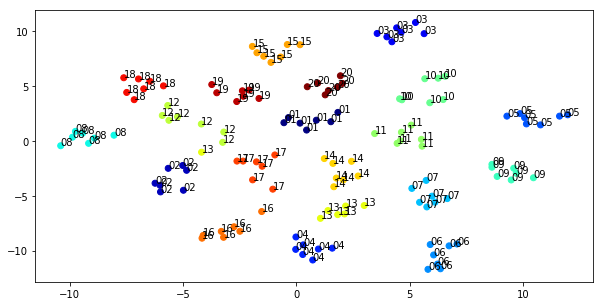

In [72]:
plotModel(train_vector, train_labels)

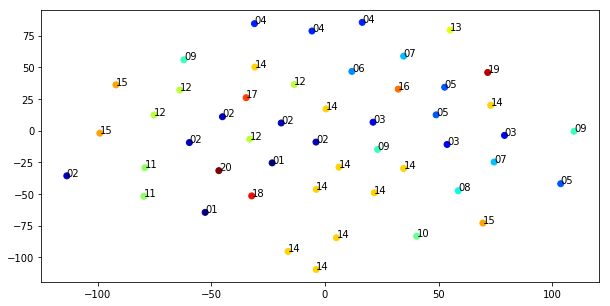

In [73]:
plotModel(test_vector, test_labels)

In [74]:
from sklearn.ensemble import BaggingClassifier;
clf = BaggingClassifier(base_estimator=LogisticRegression(),n_estimators=5);
clf.fit(train_vector,train_labels);
pred = clf.predict(test_vector)

Confusion matrix, without normalization


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                precision    recall  f1-score   support

candidate00001       1.00      1.00      1.00         2
candidate00002       0.40      0.50      0.44         4
candidate00003       0.00      0.00      0.00         0
candidate00004       1.00      0.60      0.75         5
candidate00005       0.67      0.40      0.50         5
candidate00006       1.00      1.00      1.00         1
candidate00007       0.50      1.00      0.67         1
candidate00008       1.00      0.50      0.67         2
candidate00009       0.67      0.33      0.44         6
candidate00010       1.00      0.50      0.67         2
candidate00011       0.50      0.25      0.33         4
candidate00012       0.00      0.00      0.00         1
candidate00013       1.00      1.00      1.00         1
candidate00014       0.10      1.00      0.18         1
candidate00015       1.00      0.43      0.60         7
candidate00016       1.00      1.00      1.00         1
candidate00017       0.00      0.00      0.00  

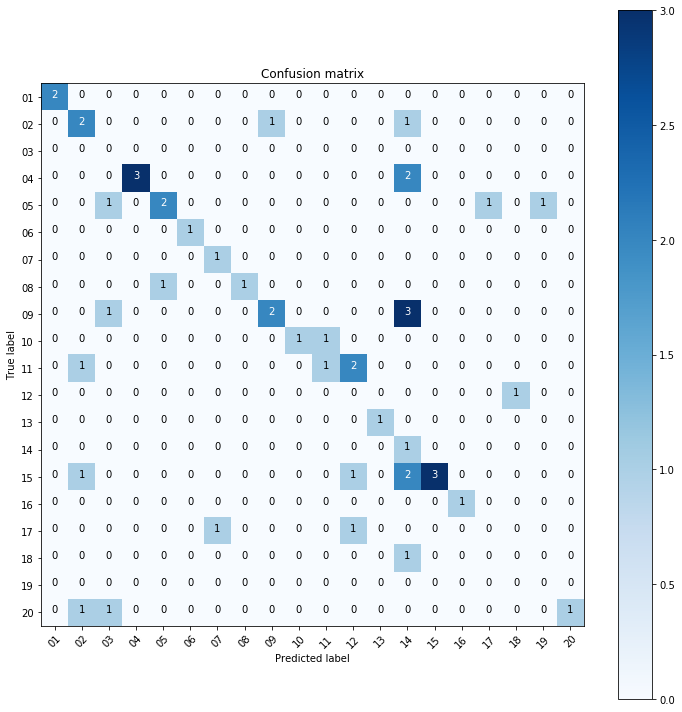

In [75]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support, classification_report
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(pred, test_labels),classes=[c[-2:] for c in clf.classes_])
print(classification_report(pred, test_labels))

In [90]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
clf = MLPClassifier(activation='logistic',
                    solver='adam',
                    max_iter=400,
                    hidden_layer_sizes=(len(set(train_labels))*10,),
                    random_state=42);
clf.fit(train_vector,train_labels);
pred = clf.predict(test_vector)

Confusion matrix, without normalization


/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                precision    recall  f1-score   support

candidate00001       0.50      0.50      0.50         2
candidate00002       0.60      0.50      0.55         6
candidate00003       0.00      0.00      0.00         0
candidate00004       1.00      0.60      0.75         5
candidate00005       0.67      0.40      0.50         5
candidate00006       0.00      0.00      0.00         0
candidate00007       0.50      1.00      0.67         1
candidate00008       0.00      0.00      0.00         1
candidate00009       0.67      0.67      0.67         3
candidate00010       1.00      1.00      1.00         1
candidate00011       1.00      0.50      0.67         4
candidate00012       0.00      0.00      0.00         1
candidate00013       1.00      1.00      1.00         1
candidate00014       0.10      1.00      0.18         1
candidate00015       1.00      0.43      0.60         7
candidate00016       1.00      0.50      0.67         2
candidate00017       0.00      0.00      0.00  

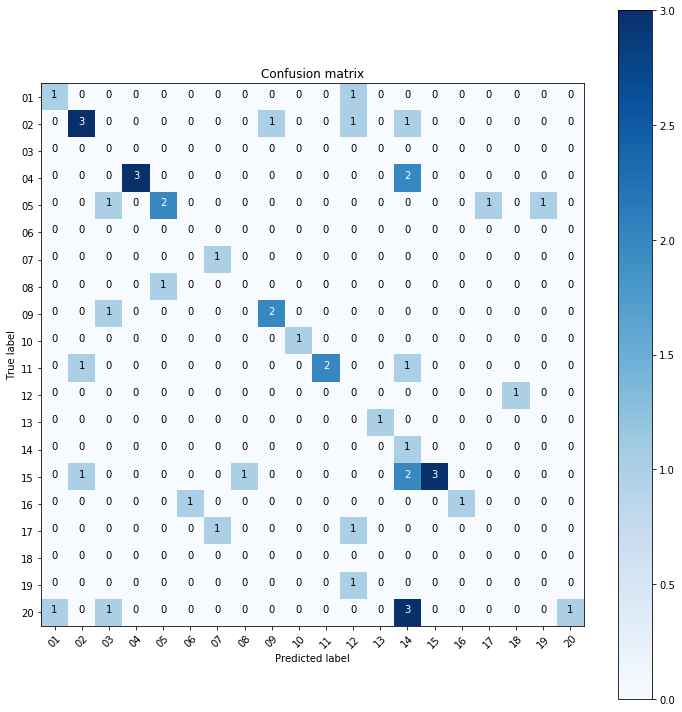

In [91]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support, classification_report
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(pred, test_labels),classes=[c[-2:] for c in clf.classes_])
print(classification_report(pred, test_labels))

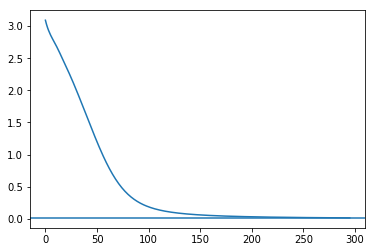

In [92]:
plt.figure()
plt.plot(clf.loss_curve_)
plt.axhline(clf.best_loss_)
plt.show()

<Figure size 432x288 with 0 Axes>

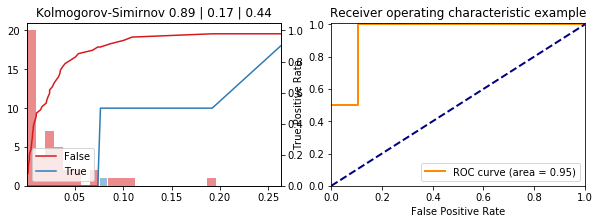

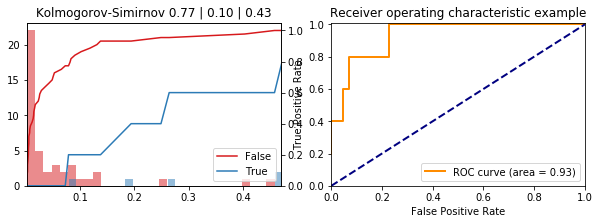

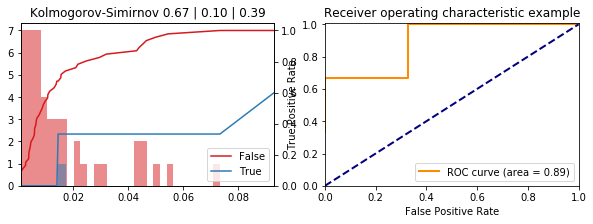

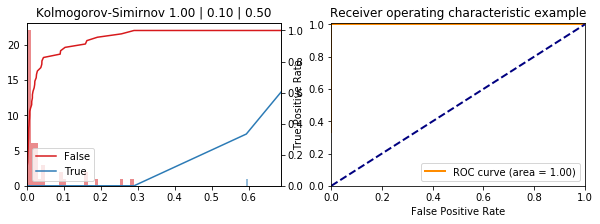

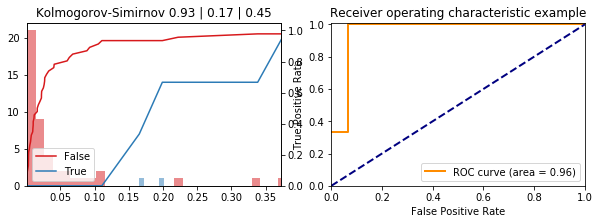

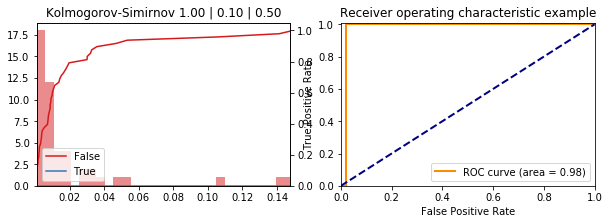

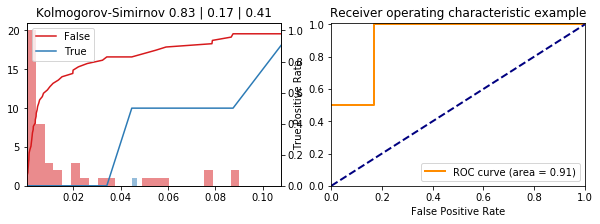

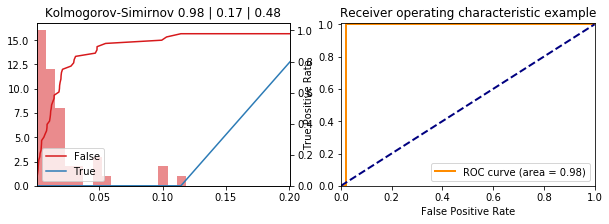

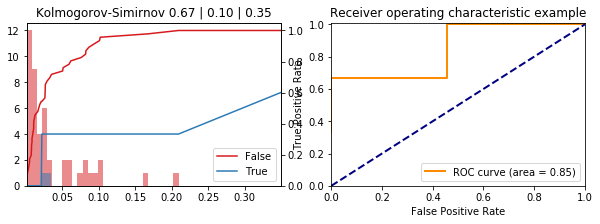

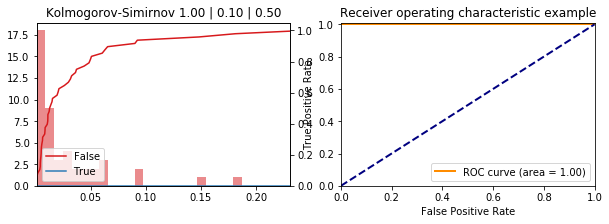

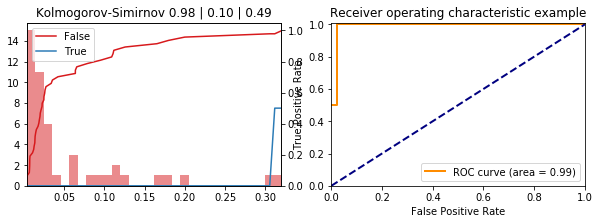

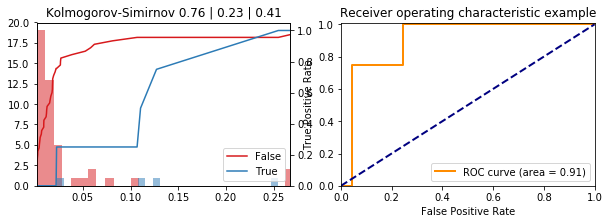

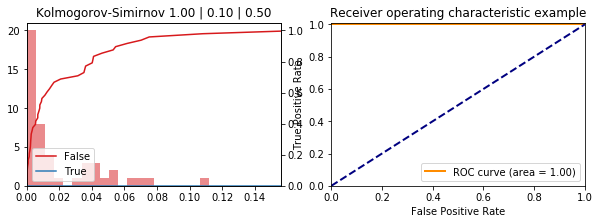

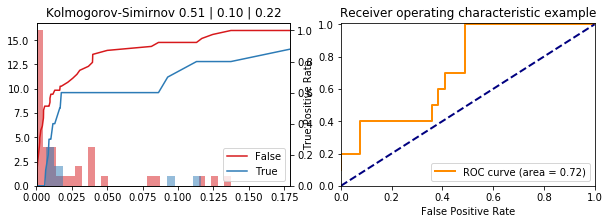

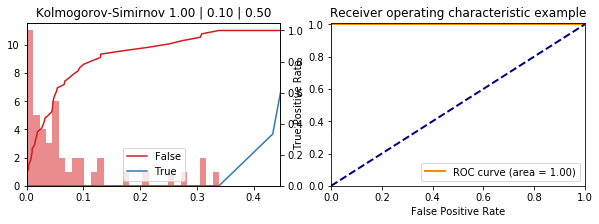

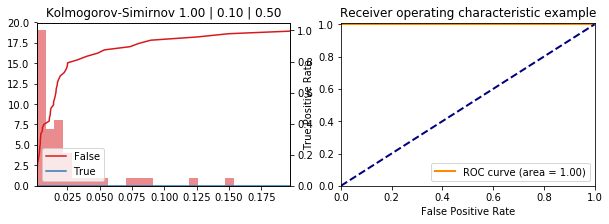

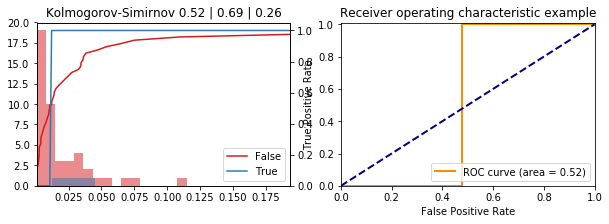

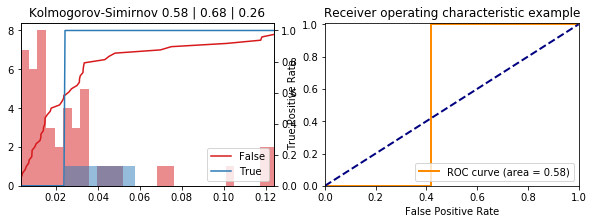

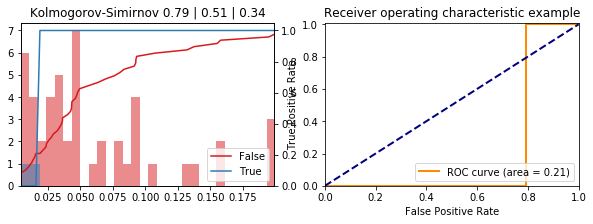

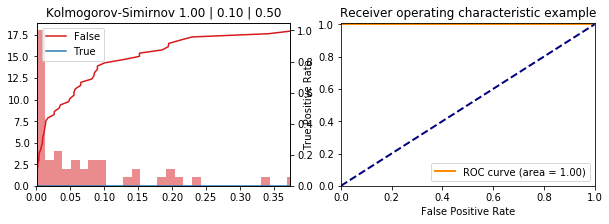

In [93]:
plt.figure();
p_test = clf.predict_proba(test_vector)
for i,_class in enumerate(clf.classes_):
    plotKSROC(p_test[:,i],test_labels==_class);
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture

lda = make_pipeline(
    CountVectorizer(analyzer='word', min_df=5, max_df=1.0, ngram_range=(1,2), lowercase=True),
    DenseTransformer(),
    LatentDirichletAllocation(n_components=len(set(train_labels))));

ltrain = lda.fit(train_docs).predict_proba(train_docs)
ltest = lda.predict_proba(test_docs)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
clf = LogisticRegression();
clf.fit((ltrain),train_labels);
pred = clf.predict((ltest))

In [ ]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support, classification_report
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(pred, test_labels),classes=[c[-2:] for c in clf.classes_])
print(classification_report(pred, test_labels))

In [ ]:
resultTime = [];
pipeline = Pipeline([
        ('vect',   TimeEmbeddingTransform(timeWindow=5)),
        #('scaler', MaxAbsScaler()),
        #('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')),
    ]);
for problem in problems:
    resultTime.append(runEnsemble(problem, pipeline));
pd.DataFrame(resultTime)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

In [ ]:
resultTime = [];
pipeline = Pipeline([
        ('vect',   TimeEmbeddingTransform(timeWindow=5)),
        ('scaler', StandardScaler()),
        #('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')),
    ]);
for problem in problems:
    resultTime.append(runEnsemble(problem, pipeline));
pd.DataFrame(resultTime)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

In [ ]:
resultTime = [];
pipeline = Pipeline([
        ('vect',   TimeEmbeddingTransform(timeWindow=100)),
        ('scaler', StandardScaler()),
        #('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')),
    ]);
for problem in problems:
    resultTime.append(runEnsemble(problem, pipeline));
pd.DataFrame(resultTime)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

In [ ]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [ ]:
resultTime = [];
pipeline = Pipeline([
        ('vect',   TimeEmbeddingTransform(timeWindow=500)),
        ('idf',    TfidfTransformer(smooth_idf=True,norm='l2')),
        ('dense',DenseTransformer()),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')),
    ]);
for problem in problems:
    resultTime.append(runEnsemble(problem, pipeline));
pd.DataFrame(resultTime)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

In [ ]:
c = int(np.ceil(np.sqrt(len(clf.classes_))))
r = int(1.0*np.ceil(len(clf.classes_)/c))
fig, axes = plt.subplots(figsize=(15,15), sharex=False, sharey=False, ncols=c, nrows=r)
for i,_class in enumerate(clf.classes_):
    plt.subplot(r,c,i+1)
    analysisPlot(p_test[:,i],y_test==_class, title=_class)

In [ ]:
for i,_class in enumerate(clf.classes_):
    plotKSROC(p_test[:,i],y_test==_class)